# Classification of [German credit dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/)

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from gibbs import GibbsSamplerProbit
from mean_field import MeanFieldProbit

sns.set()

### Extract data from file

In [2]:
colnames = list(range(1,26))
df = pd.read_csv('german.data-numeric', delim_whitespace=True, names=colnames, header=None)

### Preprocess

* normalize predictors to have zero mean and unit variance,
* add a constant column to represent an intercept in the model.

Cast into a numpy array of size $n\times p$.

In [3]:
# extract labels
y = np.array(df)[:, -1]
# relabel so that -1 is "bad" and 1 is "good"
y = 3-2*y

df = (df-df.mean(axis=0))/df.std(axis=0)
X = np.array(df)[:, :-1]

# add intercept
X = np.concatenate([X, np.ones((X.shape[0],1))], axis=1)

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)

## Gibbs Sampling

Probit model :
$$
y_i = sgn(\beta^\top x_i+\varepsilon_i),\\
\varepsilon_i∼\mathcal{N}(0,1),
$$

where $y_i=1$ corresponds to good credit, $y_i$ for bad credit for person $i$.

Given the data $x_i\in \mathbb{R}^p$, $z_i = \beta^\top x_i+\varepsilon_i \sim \mathcal{N}\big(0, \tau^2 x_i^\top x_i + 1 \big)$.
If $\varepsilon$ was replaced with $\sigma \varepsilon$, we would have $\mathcal{N}\big(0,\tau^2 x_i^\top x_i + \sigma^2 \big) = \mathcal{N}\big(0,\sigma^2(\frac{\tau^2}{\sigma^2} x_i^\top x_i + 1) \big)$ i.e the law of $\sigma z_i$ assuming $\beta$ is rescaled by $\frac{1}{\sigma}$. Since we are interested only in predicting the sign of $z_i$, an arbitrary positive factor such as $\sigma$ does not matter, we would just get different values for the weights $\beta$ when computing the estimator.

The updates for the Gibbs sampler are:

* $\beta^{t+1} \sim \mathcal{N}\big( \mu_{\beta}^t, \Sigma \big)$
    * $\Sigma = \big( \tau I_p + X^\top X\big)^{-1}$,
    * $\mu_{\beta}^t = \Sigma X^\top z^t$.
* $z^{t+1} \sim \mathcal{TN}\big(\mu_{z}^{t+1}, I_n; ]-\infty, 0]\mathbb{1}_{y_i=-1} + [0, \infty[\mathbb{1}_{y_i=1}\big)$
    * $\mu_{z}^{t+1} = X\beta^{t+1}$,
    * $\mathcal{TN}\big(m, S; [a,b] \big)$ is the truncated Gaussian distribution of mean and covariance parameters $m$ and $S$ and truncation domain $[a,b]$.

In [4]:
model = GibbsSamplerProbit(X_train, 
                           y_train,
                           Xy_eval=(X_eval, y_eval),
                           T=1000, 
                           T_warmup=500, 
                           tau=1e2,
                          )

In [5]:
model.fit()
beta = model.beta

100%|██████████| 1000/1000 [00:04<00:00, 240.57it/s, eval_accuracy=0.735]


### Posterior distribution of $\beta$

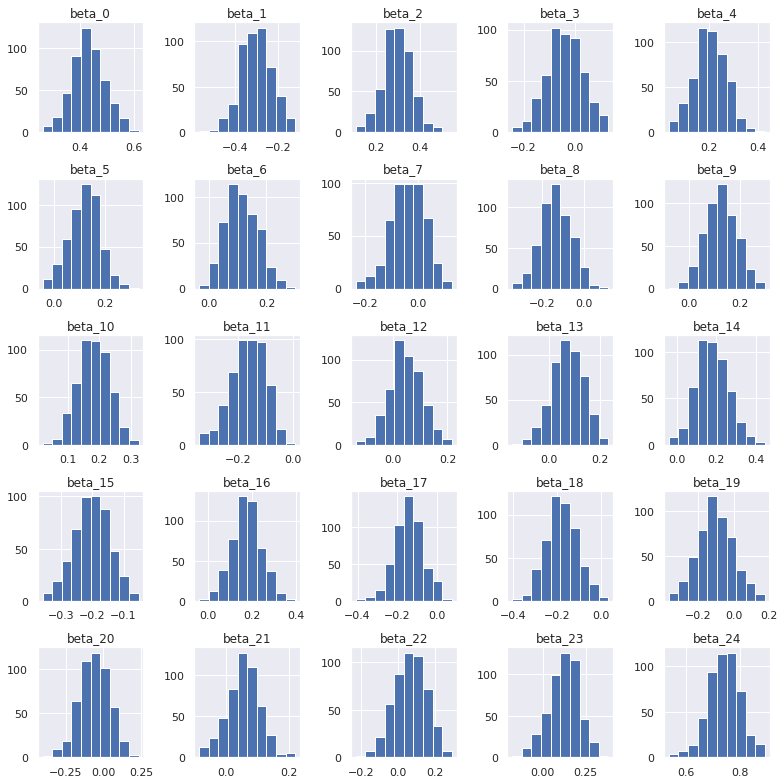

In [6]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=5, ncols=5)
for i in range(5):
    for j in range(5):
        ax = axes[i,j]
        ax.hist(beta[:, 5*i+j])
        ax.set_title('beta_{}'.format(5*i+j))
plt.tight_layout()
plt.show()

### Distribution of latent variables $z$ (at terminal time T)

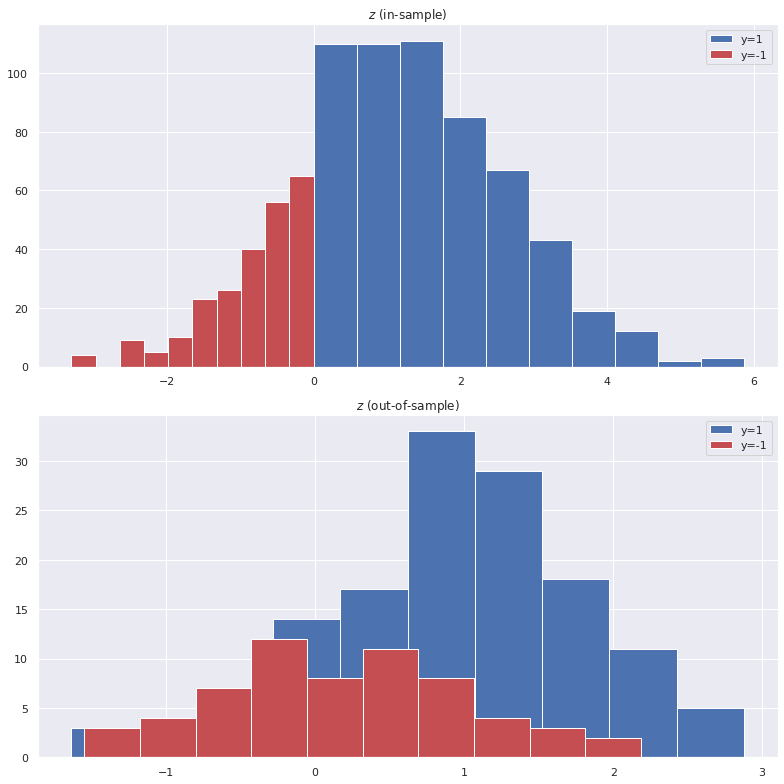

In [7]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=2, ncols=1)

ax = axes[0]
ax.hist(model.z[-1, y_train == 1], color='b', label='y=1')
ax.hist(model.z[-1, y_train == -1], color='r', label='y=-1')
ax.set_title('$z$ (in-sample)')
ax.legend(loc='upper right')

ax = axes[1]
beta_MAP = np.mean(model.beta, axis=0)
z_eval = np.dot(X_eval, beta_MAP)
ax.hist(z_eval[y_eval == 1], color='b', label='y=1')
ax.hist(z_eval[y_eval == -1], color='r', label='y=-1')
ax.set_title('$z$ (out-of-sample)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Accuracy during training (calculated on test dataset)

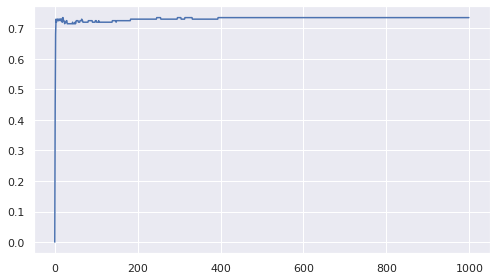

In [8]:
fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
ax.plot(model.acc)
plt.tight_layout()
plt.show()

## Variational Inference

The updates for the mean field variational inference are:

* $q^{t+1}(\beta) = \mathcal{N}\big( \mu_{\beta}^t, \Sigma \big)$
    * $\Sigma = \big( \tau I_p + X^\top X\big)^{-1}$
    * $\mu_{\beta}^t = \Sigma X^\top \mathbb{E}_{q^t(z)}\big[ z\big]$
* $q^{t+1}(z) = \mathcal{TN}\big(\mu_{z}^{t+1}, I_n; ]-\infty, 0]\mathbb{1}_{y_i=-1} + [0, \infty[\mathbb{1}_{y_i=1}\big)$
    * $\mu_{z}^{t+1} = X\mathbb{E}_{q^{t+1}(\beta)}\big[ \beta \big]$,
    * $\mathcal{TN}\big(m, S; [a,b] \big)$ is the truncated Gaussian distribution of mean and covariance parameters $m$ and $S$ and truncation domain $[a,b]$.

In [9]:
model = MeanFieldProbit(X_train, 
                        y_train,
                        Xy_eval=(X_eval, y_eval),
                        T=500, 
                        tau=1e2,
                       )

In [10]:
model.fit()
mu_beta = model.mu_beta
cov_beta = model.cov_beta

100%|██████████| 500/500 [00:01<00:00, 350.47it/s, eval_accuracy=0.735]


### Posterior distribution of $\beta$

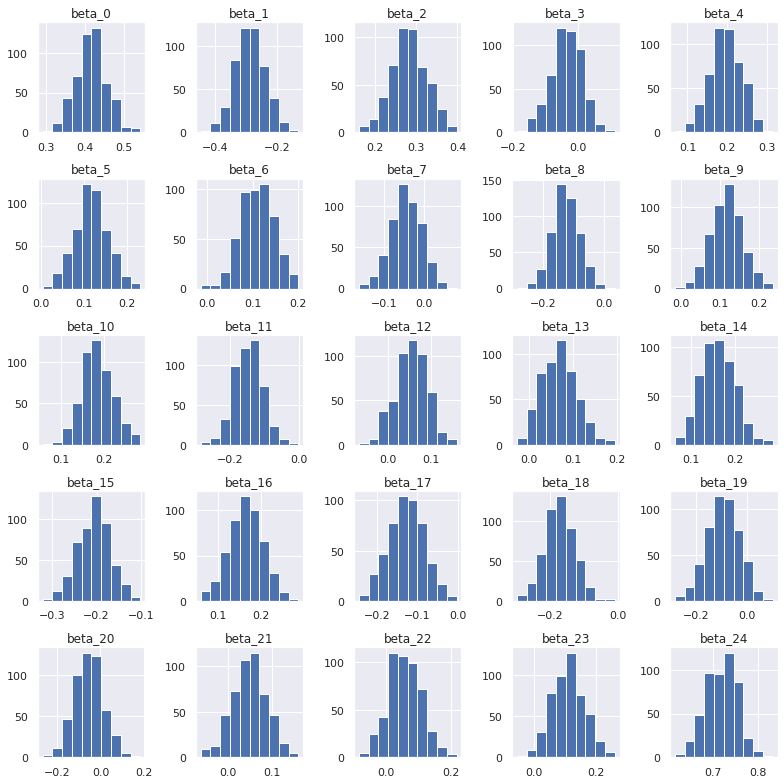

In [11]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=5, ncols=5)

beta = np.random.multivariate_normal(mu_beta, cov_beta, 500)

for i in range(5):
    for j in range(5):
        ax = axes[i,j]
        ax.hist(beta[:, 5*i+j])
        ax.set_title('beta_{}'.format(5*i+j))
plt.tight_layout()
plt.show()


### Distribution of latent variables $z=X\mu_\beta$ (at terminal time T)

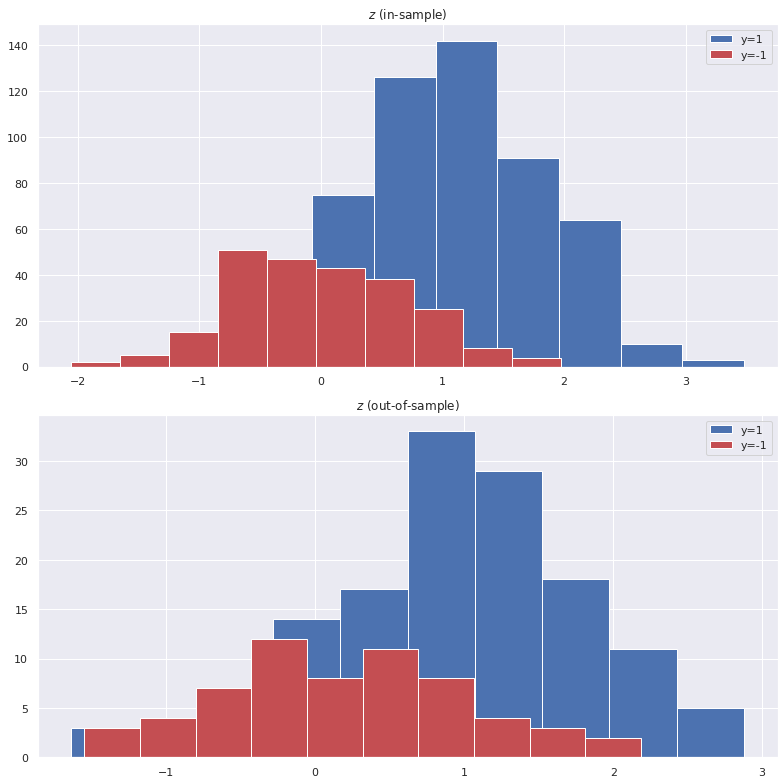

In [12]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=2, ncols=1)

ax = axes[0]
z = np.dot(X_train, model.mu_beta)
ax.hist(z[y_train == 1], color='b', label='y=1')
ax.hist(z[y_train == -1], color='r', label='y=-1')
ax.set_title('$z$ (in-sample)')
ax.legend(loc='upper right')

ax = axes[1]
z = np.dot(X_eval, model.mu_beta)
ax.hist(z_eval[y_eval == 1], color='b', label='y=1')
ax.hist(z_eval[y_eval == -1], color='r', label='y=-1')
ax.set_title('$z$ (out-of-sample)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Accuracy during training

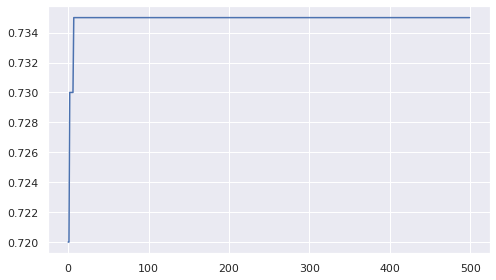

In [13]:
fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
ax.plot(model.acc)
plt.tight_layout()
plt.show()

## Complete separation

Complete separation occur when an hyperplane (of normal vector $\beta$) fully separates the two clusters.

Running the Gibbs sampler on a fully separated dataset yields perfect accuracy, even on the test set. In the 2d case, the posterior distribution of $\beta$ concentrates around a positive mean for $beta_1$ and a negative mean for $beta_2$. The posterior distribution for $z$ approaches a mixture of truncated Gaussians of mean given by $X\beta$, i.e the centroids of the Gaussians in the mixture are always positive for $y=1$ and always negative for $y=-1$ thanks to the separation assumption. As a consequence, the sign of $z$ predicts perfectly the class.

In [14]:
n = 1000
X = np.concatenate(
    [
        np.random.randn(n, 2) + [5, 0],
        np.random.randn(n, 2) + [-5, 0],
    ],
)

y = np.concatenate(
    [
        np.ones(n),
        -np.ones(n),
    ]
)

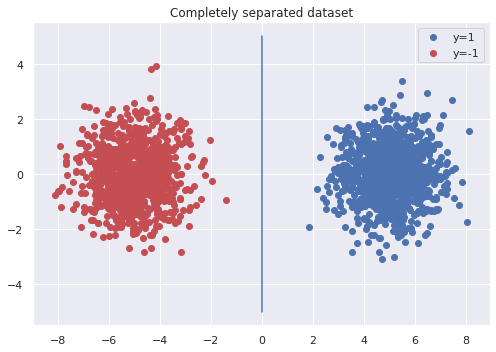

In [15]:
fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
ax.scatter(X[y==1, 0], X[y==1, 1], color='b', label='y=1')
ax.scatter(X[y==-1, 0], X[y==-1, 1], color='r', label='y=-1')
ax.plot([0, 0], [-5, 5])
ax.set_title('Completely separated dataset')
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)

model = GibbsSamplerProbit(X_train, 
                           y_train,
                           Xy_eval=(X_eval, y_eval),
                           T=1000, 
                           T_warmup=500, 
                           tau=1e2,
                          )

model.fit()
beta = model.beta

100%|██████████| 1000/1000 [00:04<00:00, 219.05it/s, eval_accuracy=1]


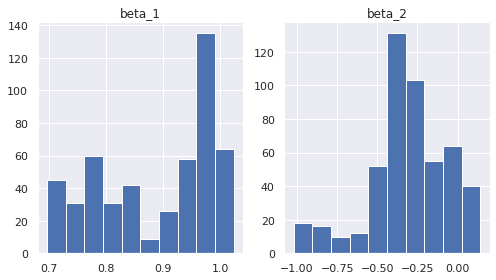

In [17]:
fig, axes = plt.subplots(figsize=(7, 4), nrows=1, ncols=2)

ax = axes[0]
ax.hist(beta[:, 0])
ax.set_title('beta_1')

ax = axes[1]
ax.hist(beta[:, 1])
ax.set_title('beta_2')

plt.tight_layout()
plt.show()

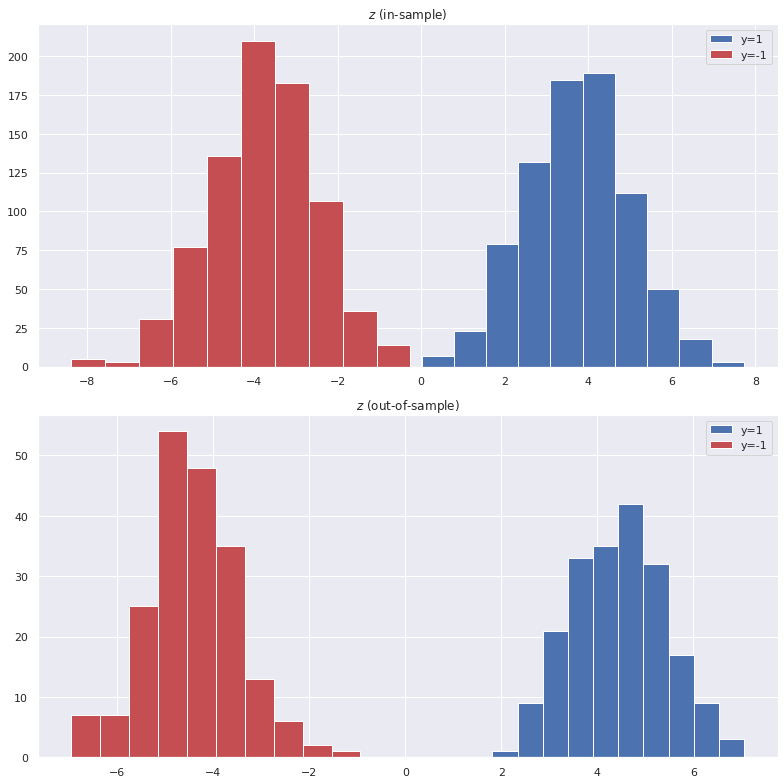

In [18]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=2, ncols=1)

ax = axes[0]
ax.hist(model.z[-1, y_train == 1], color='b', label='y=1')
ax.hist(model.z[-1, y_train == -1], color='r', label='y=-1')
ax.set_title('$z$ (in-sample)')
ax.legend(loc='upper right')

ax = axes[1]
beta_MAP = np.mean(model.beta, axis=0)
z_eval = np.dot(X_eval, beta_MAP)
ax.hist(z_eval[y_eval == 1], color='b', label='y=1')
ax.hist(z_eval[y_eval == -1], color='r', label='y=-1')
ax.set_title('$z$ (out-of-sample)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()